In [2]:
import glam
import pandas as pd
import numpy as np
import os.path
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation


In [4]:
import pymc3 as pm

In [5]:
np.random.seed(23) # from random.org

# 3.1. Hierarchical GLAM estimation and out of sample prediction

## Load data

In [6]:
# Load data
sufix = '_Like_NoBin_NUTS_31'
data = pd.read_csv('data/FF2018_data/GlamDataFF2018_Like_NoBin_31.csv')
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]
data.head()

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1
0,0,0,0,2009,1.10,0.95,0.568396,0.431604
1,0,1,0,3371,2.00,1.70,0.762332,0.237668
2,0,2,1,1700,1.10,2.30,0.446809,0.553191
3,0,3,1,7466,1.25,1.40,0.532352,0.467648
4,0,4,1,1889,2.00,2.30,0.529736,0.470264


In [7]:
Correct_sim = []
for i in range(len(data)):
    if (data.choice[i] == 1 and (data.item_value_0[i] < data.item_value_1[i])) or (data.choice[i] == 0 and (data.item_value_0[i] > data.item_value_1[i])):
        Correct_sim.append(1)
    else:
        Correct_sim.append(0)

In [8]:
data_corrects = data.copy()
data_corrects["Correct_sim"] = Correct_sim

In [9]:
dataCorr = data_corrects[data_corrects['Correct_sim'] == 1]

In [10]:
dataIncorr = data_corrects[data_corrects['Correct_sim'] == 0]

# CORRECTS
___________________________________________

## Split data in training and test sets

In [11]:
sufix = 'Like_Corrects_31'

In [12]:
train_data1 = pd.DataFrame()
test_data1 = pd.DataFrame()

for subject in data.subject.unique():
    subject_data = dataCorr[dataCorr['subject'] == subject].copy().reset_index(drop=True)
    n_trials = len(subject_data)
    
    subject_train = subject_data.iloc[np.arange(0, n_trials, 2)].copy()
    subject_test = subject_data.iloc[np.arange(1, n_trials, 2)].copy()

    test_data1 = pd.concat([test_data1, subject_test])
    train_data1 = pd.concat([train_data1, subject_train])

#test_data.to_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_test'+sufix+'.csv'))
#train_data.to_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_train'+sufix+'.csv'))

print('Split data into training ({} trials) and test ({} trials) sets...'.format(len(train_data1), len(test_data1)))

Split data into training (1225 trials) and test (1211 trials) sets...


## Hierarchical GLAM estimation

### 1. full GLAM

In [13]:
# Fitting full GLAM
print('Fitting full GLAM hierarchically...')

glam_full = glam.GLAM(train_data1)

if not os.path.exists(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy')):
    glam_full.make_model('hierarchical', gamma_bounds=(-1, 1), t0_val=0)
    glam_full.fit(method='NUTS', tune=1000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))   
# Save parameter estimates
#np.save(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'), glam_full.estimates)
pd.DataFrame(glam_full.estimates)

Fitting full GLAM hierarchically...
  Found old parameter estimates in "results/estimates". Skipping estimation...


ValueError: Must pass 2-d input

In [14]:
# Compute WAICs
print('Computing WAIC scores for full model...')
if not os.path.exists(str('results/waic/glam_FF2018_full'+ sufix +'.npy')):
    # Note: DIC computation does not work for ADVI fitted models
    # But we are using WAIC
    glam_full.compute_waic()
else:
    print('  Found old DIC scores in "results/waic". Skipping WAIC computation...')
    glam_full.waic = np.load(str('results/waic/glam_FF2018_full'+ sufix +'.npy'))

# Compute WAICs
np.save(str('results/waic/glam_FF2018_full'+ sufix +'.npy'), glam_full.waic)

Computing WAIC scores for full model...
  Found old DIC scores in "results/waic". Skipping WAIC computation...


In [15]:
glam_full.waic

array([2.06606875e+04, 0.00000000e+00, 6.75472226e+01, 1.00000000e+00])

In [16]:
# Compute LOO

glam_full.loo = pm.loo(trace=glam_full.trace, model=glam_full.model)
glam_full.loo
np.save(str('results/loo/glam_FF2018_full'+ sufix +'.npy'), glam_full.loo)

AttributeError: 'GLAM' object has no attribute 'trace'

In [17]:
glam_full.loo

AttributeError: 'GLAM' object has no attribute 'loo'

In [18]:
# Predictions
print('Predicting test set data using full GLAM...')
glam_full.exchange_data(test_data1)

if not os.path.exists(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv')):
    glam_full.predict(n_repeats=50)
    glam_full.prediction.to_csv(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical full GLAM predictions in "results/predictions". Skipping prediction...')
    glam_full.prediction = pd.read_csv(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv'))

glam_full.prediction.head()

Predicting test set data using full GLAM...
Replaced attached data (1225 trials) with new data (1211 trials)...
  Found old hierarchical full GLAM predictions in "results/predictions". Skipping prediction...


,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1
0,0.0,0.0,0.0,0.0,2223.0,2.0,0.762332,1.7,0.237668
1,0.0,0.0,1.0,0.0,1464.0,2.0,0.762332,1.7,0.237668
2,0.0,0.0,2.0,0.0,2144.0,2.0,0.762332,1.7,0.237668
3,0.0,0.0,3.0,0.0,2551.0,2.0,0.762332,1.7,0.237668
4,0.0,0.0,4.0,0.0,2730.0,2.0,0.762332,1.7,0.237668


# INCORRECTS
___________________________________________

## Split data in training and test sets

In [19]:
sufix = 'Like_Incorrects_31'

In [20]:
train_data2 = pd.DataFrame()
test_data2 = pd.DataFrame()

for subject in data.subject.unique():
    subject_data = dataIncorr[dataIncorr['subject'] == subject].copy().reset_index(drop=True)
    n_trials = len(subject_data)
    
    subject_train = subject_data.iloc[np.arange(0, n_trials, 2)].copy()
    subject_test = subject_data.iloc[np.arange(1, n_trials, 2)].copy()

    test_data2 = pd.concat([test_data2, subject_test])
    train_data2 = pd.concat([train_data2, subject_train])

#test_data.to_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_test'+sufix+'.csv'))
#train_data.to_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_train'+sufix+'.csv'))

print('Split data into training ({} trials) and test ({} trials) sets...'.format(len(train_data2), len(test_data2)))

Split data into training (649 trials) and test (635 trials) sets...


## Hierarchical GLAM estimation

### 1. full GLAM

In [21]:
# Fitting full GLAM
print('Fitting full GLAM hierarchically...')

glam_full2 = glam.GLAM(train_data2)

if not os.path.exists(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy')):
    glam_full2.make_model('hierarchical', gamma_bounds=(-1, 1), t0_val=0)
    glam_full2.fit(method='NUTS', tune=1000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_full2.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))   
# Save parameter estimates
#np.save(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'), glam_full2.estimates)
pd.DataFrame(glam_full2.estimates)

Fitting full GLAM hierarchically...
  Found old parameter estimates in "results/estimates". Skipping estimation...


ValueError: Must pass 2-d input

In [22]:
# Compute WAICs
print('Computing WAIC scores for full model...')
if not os.path.exists(str('results/waic/glam_FF2018_full'+ sufix +'.npy')):
    # Note: DIC computation does not work for ADVI fitted models
    # But we are using WAIC
    glam_full2.compute_waic()
else:
    print('  Found old DIC scores in "results/waic". Skipping WAIC computation...')
    glam_full2.waic = np.load(str('results/waic/glam_FF2018_full'+ sufix +'.npy'))

# Compute WAICs
np.save(str('results/waic/glam_FF2018_full'+ sufix +'.npy'), glam_full2.waic)

Computing WAIC scores for full model...
  Found old DIC scores in "results/waic". Skipping WAIC computation...


In [23]:
glam_full2.waic

array([1.18082967e+04, 0.00000000e+00, 8.26179236e+01, 1.00000000e+00])

In [24]:
# Compute LOO

glam_full2.loo = pm.loo(trace=glam_full2.trace, model=glam_full2.model)
glam_full2.loo
np.save(str('results/loo/glam_FF2018_full'+ sufix +'.npy'), glam_full2.loo)

AttributeError: 'GLAM' object has no attribute 'trace'

In [25]:
glam_full2.loo

AttributeError: 'GLAM' object has no attribute 'loo'

In [26]:
# Predictions
print('Predicting test set data using full GLAM...')
glam_full2.exchange_data(test_data2)

if not os.path.exists(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv')):
    glam_full2.predict(n_repeats=50)
    glam_full2.prediction.to_csv(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical full GLAM predictions in "results/predictions". Skipping prediction...')
    glam_full2.prediction = pd.read_csv(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv'))

glam_full2.prediction.head()

Predicting test set data using full GLAM...
Replaced attached data (649 trials) with new data (635 trials)...
  Found old hierarchical full GLAM predictions in "results/predictions". Skipping prediction...


,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1
0,0.0,0.0,0.0,0.0,3229.0,2.0,0.585313,2.0,0.414687
1,0.0,0.0,1.0,0.0,1415.0,2.0,0.585313,2.0,0.414687
2,0.0,0.0,2.0,0.0,2022.0,2.0,0.585313,2.0,0.414687
3,0.0,0.0,3.0,0.0,2949.0,2.0,0.585313,2.0,0.414687
4,0.0,0.0,4.0,0.0,2858.0,2.0,0.585313,2.0,0.414687


## 2. Plot fit Correct vs Incorrect

## Correct

Close Figure to continue...


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


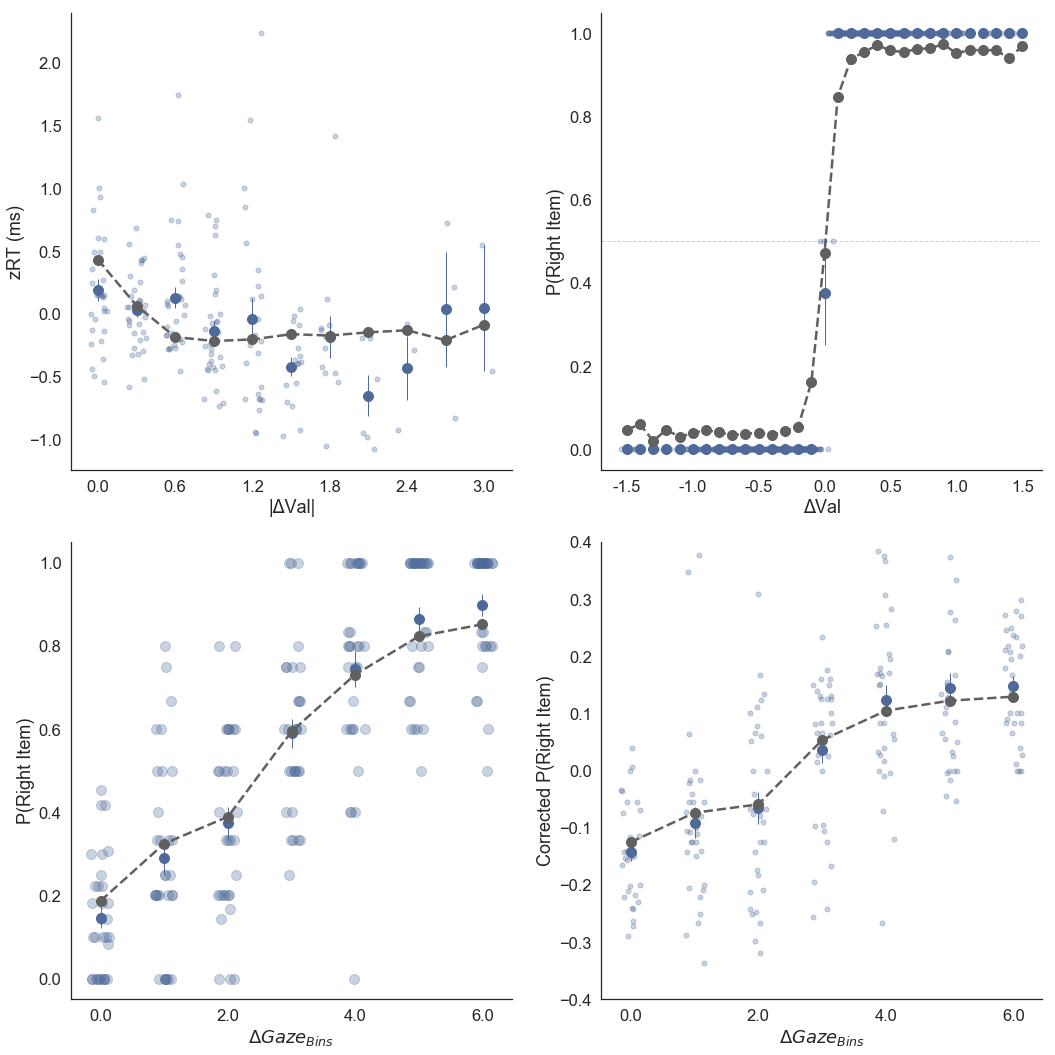

In [29]:
print('Close Figure to continue...')
glam.plot_fit(test_data1, glam_full.prediction);
plt.show()

## Incorrect

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


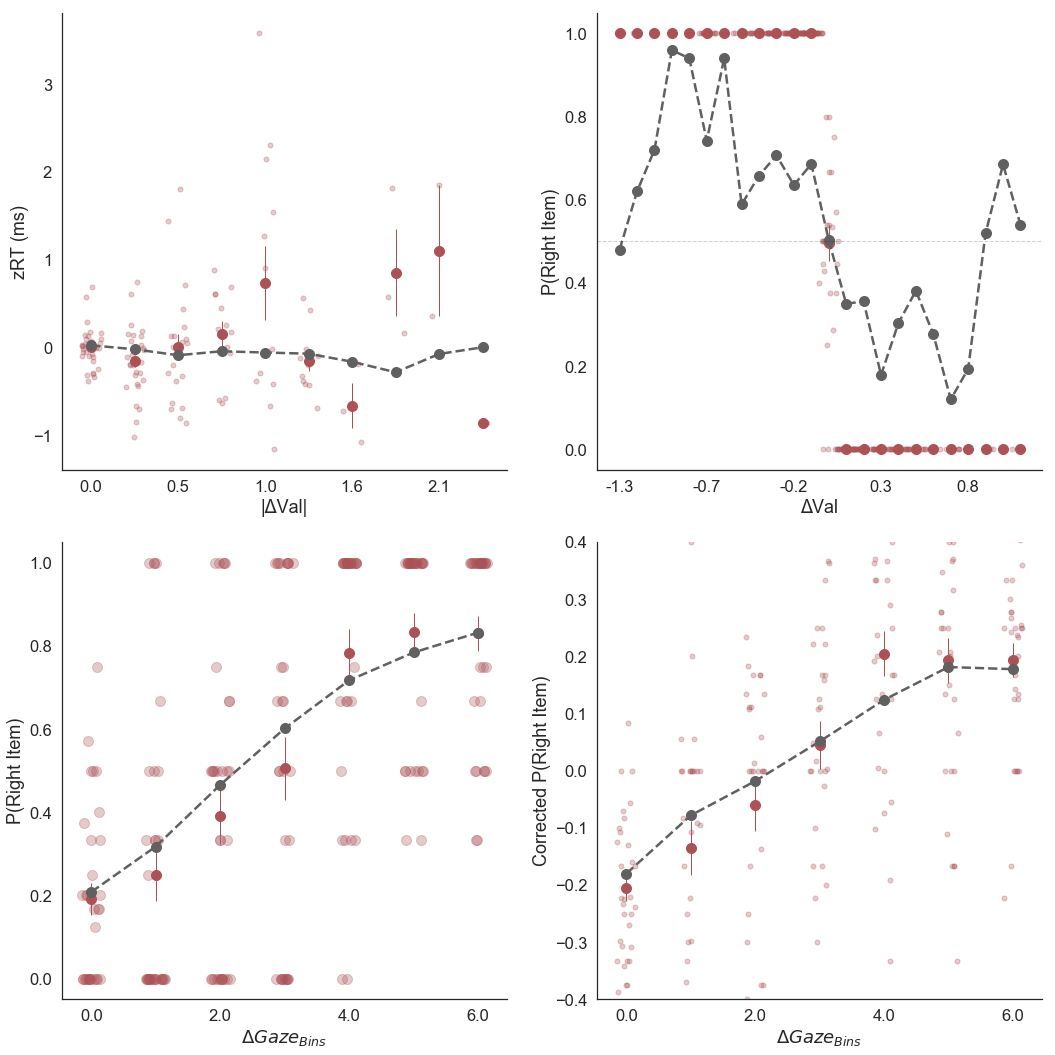

In [28]:
glam.plot_fit(test_data2, glam_full2.prediction,color_data = '#AC5255');
plt.show()

# Plot params for correct incorrect fit

In [69]:
def ttestsPlot(data1, data2,c1 ='#4F6A9A',c2 = '#AC5255',lab1 = "Like", lab2 = "Dislike",title = ''):

    # t-TEST
    diff = data1.mean() - data2.mean()
    [s, p] = stats.ttest_rel(data1,data2)
    print ("ChoiceSlopes: MeanL = "+ str(round(data1.mean(),2))+ "; MeanD = "+ str(round(data2.mean(),2))+"; [Like - Dislike] =  " + str(round(diff,2) ) +"; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)) )
    
        
    # PLOT LIKE AND DISLIKE VARIABILITY
        
    # Set seaborn style for the plot
    #fig = plt.figure(figsize=[6,10])
    sns.set(style='white',font_scale=1.5)
    jittr = np.random.uniform(low=-0.3,high=0.3,size=len(data1))    
    plt.scatter([1]*len(data1)+jittr, data1, c= c1, alpha=0.7,label=lab1)
    plt.scatter([2]*len(data2)+jittr, data2, c= c2, alpha=0.7,label=lab2)
    
    ## add lines between slope points in like and dislike for each participant
    
    for i in range(len(data1)):
        plt.plot( [1 + jittr[i],2 + jittr[i]], [ data1[i] , data2[i]],'--', lw=1.0, color = 'black', alpha = 0.2)
        #if data1[i]<data2[i]:
            #print ("Participants with slope in Like < Dislike: " + str(i))
            
    
    #legend(loc = 'best')
    plt.xticks([1, 2,], [lab1, lab2],fontsize=18)
    plt.ylabel(title, fontsize=18)
    sns.despine()

ChoiceSlopes: MeanL = 0.85; MeanD = -0.97; [Like - Dislike] =  1.82; t =  660.14 ; p-value =0.0
ChoiceSlopes: MeanL = 4.93; MeanD = 1.94; [Like - Dislike] =  2.99; t =  17.91 ; p-value =0.0
ChoiceSlopes: MeanL = 0.0; MeanD = 0.0; [Like - Dislike] =  -0.0; t =  -4.82 ; p-value =0.0
ChoiceSlopes: MeanL = 0.01; MeanD = 0.01; [Like - Dislike] =  -0.0; t =  -1.17 ; p-value =0.25


(0.004, 0.012)

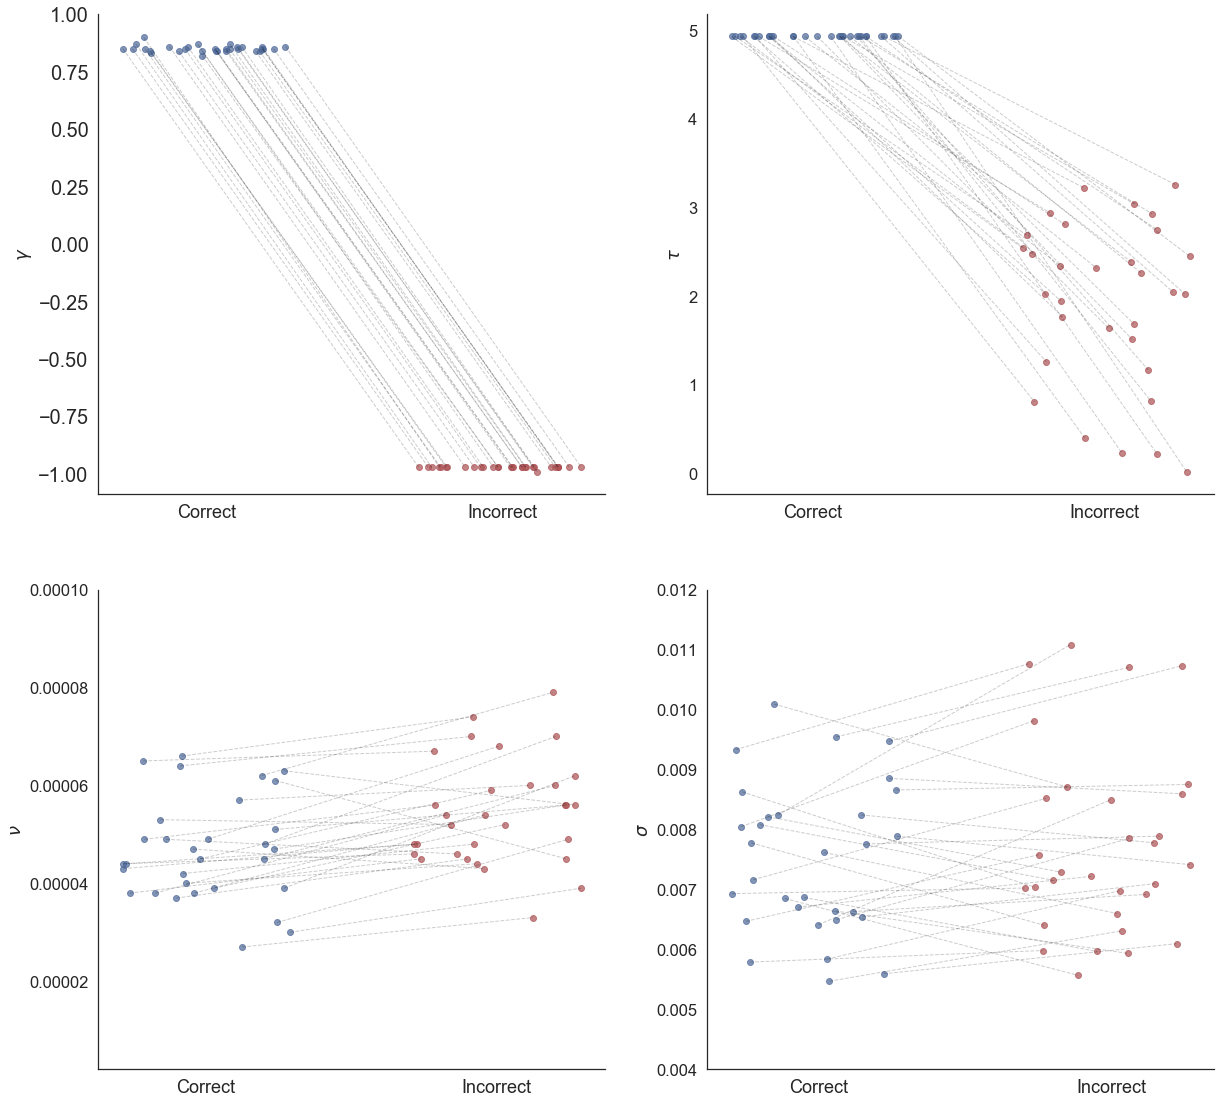

In [71]:
params_corr = pd.DataFrame.from_dict(glam_full.estimates.item(0))
params_incorr = pd.DataFrame.from_dict(glam_full2.estimates.item(0))

f = plt.figure(figsize=(20,30))
sns.set(style='white', font_scale=1.8)

label_blu = 'Correct'
label_red = 'Incorrect'

plt.subplot(321)
ttestsPlot(params_corr.gamma, params_incorr.gamma,'#4F6A9A','#AC5255',label_blu,label_red,title = '$\gamma$')
plt.subplot(322)
ttestsPlot(params_corr.tau, params_incorr.tau,'#4F6A9A','#AC5255',label_blu,label_red,title = r'$\tau$')
plt.subplot(323)
ttestsPlot(params_corr.v, params_incorr.v,'#4F6A9A','#AC5255',label_blu,label_red,title = r'$\nu$')
plt.ylim(0.000002, 0.0001)
plt.subplot(324)
ttestsPlot(params_corr.s, params_incorr.s,'#4F6A9A','#AC5255',label_blu,label_red,title = '$\sigma$')
plt.ylim(0.004,0.012 )